In [1]:
%cd ..

c:\Projects\Groningen-Waste-Collection


In [2]:
import glob
import json

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd

In [3]:
def load(files: list[str]) -> pd.DataFrame:
    data = []
    for file in files:
        with open(file, "r") as fh:
            data.append(json.load(fh))
    
    df = pd.DataFrame(data)
    df["experiment"] = range(1, len(files) + 1)
    df["avg_distance_per_day"] = df["avg_route_distance"] * df["avg_num_routes_per_day"]

    return df

In [4]:
greedy = load(sorted(glob.glob("out/greedy_*.json")))
greedy

,avg_excess_volume,avg_fill_factor,avg_num_arrivals_between_service,avg_num_routes_per_day,avg_route_distance,avg_route_duration,avg_route_stops,avg_service_level,num_arrivals_per_hour,num_arrivals,num_services,experiment,avg_distance_per_day
0,391.001281,0.904680,85.212089,3.677778,62051.383686,7:10:38.712991,67.975831,0.782311,"[11903, 5913, 3516, 2696, 2371, 4229, 11805, 3...",1971050,22500,1,228211.200000
1,403.095253,0.905860,85.266800,3.677778,61754.848943,7:10:51.794562,67.975831,0.778533,"[11798, 6047, 3502, 2668, 2388, 4381, 11791, 3...",1971952,22500,2,227120.611111
2,405.263608,0.905582,85.277822,3.655556,62084.762918,7:13:00.562310,68.389058,0.781644,"[11900, 5931, 3472, 2719, 2296, 4479, 11771, 3...",1972136,22500,3,226954.300000
3,397.683263,0.905380,85.251244,3.633333,62722.788991,7:16:04.076453,68.807339,0.781111,"[12107, 5978, 3415, 2600, 2427, 4347, 11624, 3...",1971654,22500,4,227892.800000
4,386.448937,0.903606,85.089333,3.666667,62189.600000,7:12:31.315152,68.181818,0.784756,"[11839, 5943, 3461, 2693, 2317, 4362, 11768, 3...",1968413,22500,5,228028.533333
5,393.475093,0.904826,85.196311,3.655556,62133.155015,7:13:02.550152,68.389058,0.781422,"[11911, 5867, 3474, 2666, 2359, 4347, 11642, 3...",1970857,22500,6,227131.200000
6,403.563088,0.906096,85.340756,3.655556,62576.465046,7:13:59.246201,68.389058,0.779244,"[11952, 6028, 3459, 2651, 2441, 4204, 11661, 3...",1973469,22500,7,228751.744444
7,401.727317,0.904063,85.151556,3.711111,61583.017964,7:07:09.697605,67.365269,0.783022,"[11781, 5949, 3488, 2754, 2486, 4339, 11791, 3...",1969489,22500,8,228541.422222
8,392.864730,0.904795,85.203600,3.733333,61190.360119,7:04:39.803571,66.964286,0.782756,"[11929, 6095, 3492, 2652, 2474, 4241, 11880, 3...",1970570,22500,9,228444.011111
9,407.036402,0.905528,85.286533,3.666667,62211.457576,7:12:05.354545,68.181818,0.782667,"[11908, 5808, 3453, 2773, 2410, 4377, 11935, 3...",1972658,22500,10,228108.677778


In [5]:
baseline = load(sorted(glob.glob("out/baseline_*.json")))
baseline

,avg_excess_volume,avg_fill_factor,avg_num_arrivals_between_service,avg_num_routes_per_day,avg_route_distance,avg_route_duration,avg_route_stops,avg_service_level,num_arrivals_per_hour,num_arrivals,num_services,experiment,avg_distance_per_day
0,376.274723,0.904485,85.202667,3.688889,61901.530120,7:09:26.915663,67.771084,0.785467,"[11903, 5913, 3516, 2696, 2371, 4229, 11805, 3...",1971050,22500,1,228347.866667
1,372.967911,0.905463,85.237111,3.633333,62611.339450,7:15:33.645260,68.807339,0.783644,"[11798, 6047, 3502, 2668, 2388, 4381, 11791, 3...",1971952,22500,2,227487.866667
2,373.476584,0.905552,85.276089,3.688889,61857.539157,7:08:52.478916,67.771084,0.782356,"[11900, 5931, 3472, 2719, 2296, 4479, 11771, 3...",1972136,22500,3,228185.588889
3,369.989612,0.905155,85.230356,3.700000,61430.186186,7:08:00.993994,67.567568,0.781867,"[12107, 5978, 3415, 2600, 2427, 4347, 11624, 3...",1971654,22500,4,227291.688889
4,375.514748,0.903625,85.085289,3.622222,62744.162577,7:17:10.576687,69.018405,0.788667,"[11839, 5943, 3461, 2693, 2317, 4362, 11768, 3...",1968413,22500,5,227273.300000
5,373.465115,0.904844,85.203200,3.655556,62186.224924,7:13:12.337386,68.389058,0.788267,"[11911, 5867, 3474, 2666, 2359, 4347, 11642, 3...",1970857,22500,6,227325.200000
6,376.270863,0.906046,85.341378,3.588889,63006.396285,7:20:06.154799,69.659443,0.781956,"[11952, 6028, 3459, 2651, 2441, 4204, 11661, 3...",1973469,22500,7,226122.955556
7,368.248270,0.903996,85.144978,3.600000,63007.716049,7:19:07.978395,69.444444,0.787200,"[11781, 5949, 3488, 2754, 2486, 4339, 11791, 3...",1969489,22500,8,226827.777778
8,374.967838,0.904528,85.186711,3.588889,63109.582043,7:20:46.820433,69.659443,0.789378,"[11929, 6095, 3492, 2652, 2474, 4241, 11880, 3...",1970570,22500,9,226493.277778
9,375.437324,0.904992,85.231378,3.644444,62010.399390,7:13:31.213415,68.597561,0.782800,"[11908, 5808, 3453, 2773, 2410, 4377, 11935, 3...",1972658,22500,10,225993.455556


In [6]:
prize = load(sorted(glob.glob("out/prize_*.json")))
prize

,avg_excess_volume,avg_fill_factor,avg_num_arrivals_between_service,avg_num_routes_per_day,avg_route_distance,avg_route_duration,avg_route_stops,avg_service_level,num_arrivals_per_hour,num_arrivals,num_services,num_unserved_containers,experiment,avg_distance_per_day
0,878.236496,0.504745,47.531293,4.911602,55724.691789,8:28:04.392576,92.973003,0.985046,"[24048, 12228, 7027, 5298, 4848, 8881, 23661, ...",3962241,82653,5,1,273697.519337
1,899.250133,0.499222,47.004367,4.950276,55350.684152,8:28:33.591518,93.282366,0.986983,"[23717, 12338, 7086, 5470, 4796, 8690, 23818, ...",3965008,83581,5,2,274001.176796
2,908.409015,0.500318,47.103265,4.988950,55132.846069,8:24:40.489480,92.430786,0.986557,"[23955, 12100, 6930, 5416, 4789, 8616, 23868, ...",3964549,83465,5,3,275055.027624
3,853.774798,0.493093,46.433856,5.038674,54664.452851,8:24:37.370614,92.750000,0.986192,"[23912, 12255, 7031, 5376, 4710, 8674, 23791, ...",3964891,84588,5,4,275436.359116
4,886.280727,0.490074,46.141515,5.077348,54913.681175,8:24:03.032644,92.570185,0.986976,"[24107, 11987, 6958, 5355, 4701, 8675, 24016, ...",3962079,85072,5,5,278815.872928
5,937.823894,0.496789,46.786183,5.011050,55093.811466,8:24:52.858875,92.547960,0.986610,"[24008, 12139, 7063, 5336, 4883, 8704, 23903, ...",3962278,83941,5,6,276077.828729
6,896.990963,0.494049,46.514181,5.016575,55007.362335,8:26:28.915198,92.958150,0.985439,"[24003, 12175, 6844, 5284, 4724, 8593, 23733, ...",3961545,84406,5,7,275948.535912
7,857.389434,0.495303,46.642754,5.000000,55192.816575,8:27:32.658564,93.093923,0.986255,"[24063, 12140, 6884, 5563, 4807, 8683, 23586, ...",3959795,84250,5,8,275964.082873
8,918.857490,0.492069,46.332991,5.066298,54685.286805,8:23:30.919302,92.486369,0.986098,"[23849, 12326, 6934, 5254, 4772, 8655, 23686, ...",3962789,84810,5,9,277051.977901
9,849.183106,0.492547,46.369792,5.044199,55010.953998,8:25:08.021906,92.740416,0.986253,"[24057, 12110, 6954, 5261, 4684, 8721, 24016, ...",3963158,84672,5,10,277486.193370


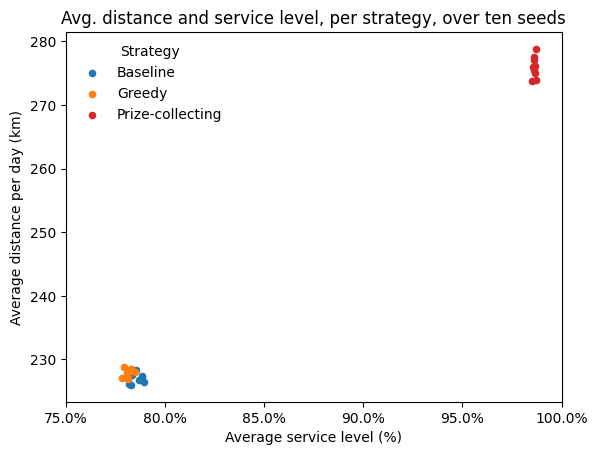

In [7]:
_, ax = plt.subplots()

baseline.plot.scatter(
    x="avg_service_level",
    y="avg_distance_per_day", 
    ax=ax,
    label="Baseline",
    color="tab:blue"
)

greedy.plot.scatter(
    x="avg_service_level",
    y="avg_distance_per_day",
    ax=ax,
    label="Greedy",
    color="tab:orange"
)

prize.plot.scatter(
    x="avg_service_level",
    y="avg_distance_per_day",
    ax=ax,
    label="Prize-collecting",
    color="tab:red"  
)

ticks = mtick.FuncFormatter(lambda x, pos: '{0:g}'.format(x / 1_000))
ax.yaxis.set_major_formatter(ticks)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_xlim([0.75, 1])

ax.legend(frameon=False, title="Strategy")
ax.set_title("Avg. distance and service level, per strategy, over ten seeds")
ax.set_xlabel("Average service level (%)")
ax.set_ylabel("Average distance per day (km)");
